# Apprentice Chef - Classification Model Development

> *by Jack Daoud, February 14th 2021*

<br><br>

# Setup

In [1]:
# Set up environment with libraries & data

##############################################################################
# Import libraries

import pandas as pd                     # data sceince essentials
import matplotlib.pyplot as plt         # essential graphical output
import seaborn as sns                   # enhanced visualizations
import numpy as np                      # mathematical essentials
import time                             # time essentials
import itertools

t0 = time.time()                        # start time of script


from sklearn.feature_selection import SelectFromModel   # feature selection
from sklearn.model_selection import train_test_split    # train-test split
from sklearn.model_selection import RandomizedSearchCV  # hyperparameter tuning
from sklearn.linear_model import LogisticRegression     # logistic regression

import statsmodels.formula.api as smf                   # logistic regression

from sklearn import metrics                             # metrics
from sklearn.metrics import confusion_matrix            # confusion matrix
from sklearn.metrics import roc_auc_score               # auc score
from sklearn.metrics import classification_report       # classification report
from sklearn.metrics import make_scorer                 # customizable scorer



from sklearn.cluster import KMeans                      # KMeans for segmentation

from sklearn.preprocessing import StandardScaler        # standard scaler
from sklearn.preprocessing import MinMaxScaler          # minmax scaler
from sklearn.preprocessing import RobustScaler          # robust scaler

from sklearn.neighbors import KNeighborsClassifier      # KNN for classification

from sklearn.tree import DecisionTreeClassifier         # classification trees
from sklearn.tree import export_graphviz                # exports graphics

from sklearn.ensemble import RandomForestClassifier     # random forest
from sklearn.ensemble import GradientBoostingClassifier # gbm

from six import StringIO                                # saves objects in memory
from IPython.display import Image                       # displays on frontend
import pydotplus                                        # interprets dot objects





# Set Pandas print options
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

##############################################################################
# Import data

# Specify file name
file_data = './_data/Apprentice_Chef_Dataset.xlsx'

# Read file into Python
chefs = pd.read_excel(io     = file_data,
                      header = 0)

##############################################################################
# Fix data

# Rename LARGEST_ORDER_SIZE to AVG_MEALS_ORDERED
chefs.rename(columns={'LARGEST_ORDER_SIZE':'AVG_MEALS_ORDERED'}, inplace=True)

# Print dimensions of data
print(f"""
Size of Original Dataset
------------------------
Observations: {chefs.shape[0]}
Features:     {chefs.shape[1]}
""")


Size of Original Dataset
------------------------
Observations: 1946
Features:     28



In [2]:
# User defined functions


########################################
# confusion_matrix
########################################
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("""
Normalized confusion matrix""")
#    else:
#        print("""
#Confusion matrix, without normalization""")

#    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Source of function: ML with Python by IBM on Coursera


########################################
# display_tree
########################################
def display_tree(tree, feature_df, height = 500, width = 800):
    """
    PARAMETERS
    ----------
    tree       : fitted tree model object
        fitted CART model to visualized
    feature_df : DataFrame
        DataFrame of explanatory features (used to generate labels)
    height     : int, default 500
        height in pixels to which to constrain image in html
    width      : int, default 800
        width in pixels to which to constrain image in html
    """

    # visualizing the tree
    dot_data = StringIO()

    
    # exporting tree to graphviz
    export_graphviz(decision_tree      = tree,
                    out_file           = dot_data,
                    filled             = True,
                    rounded            = True,
                    special_characters = True,
                    feature_names      = feature_df.columns)


    # declaring a graph object
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())


    # creating image
    img = Image(graph.create_png(),
                height = height,
                width  = width)
    
    return img


########################################
# flag_above_average
########################################
def flag_above_average(data, variable):
    """
    This function takes in a dataframe and a variable.
    
    Then, it calculates average of the variable.
    
    Then, it flags any data point that precedes the mean of the variable and
    calls the new variable above_avg_VARIABLE
    
    -----------
    Parameters:
    - DATA: dataframe
    - VARIABLE: column within dataframe
    """
    # Create placeholder for average flag
    data['above_avg_'+variable] = 0
    
    # Instantiate average of variable
    average = data[variable].mean()
    
    # Loop over each column to change its respective flag
    for index, column in data.iterrows():
        
        # Set conditional for variable & upper threshold
        if data.loc[index, variable] > average:
            
            # Change average flag
            data.loc[index, 'above_avg_'+variable] = 1
    
    # Check for any variables with < 100 samples and delete them
    if data['above_avg_'+variable].sum() < 100:
        del data['above_avg_'+variable]
        

########################################
# flag_outliers
########################################
def flag_outliers(data, variable):
    """
    This function takes in a dataframe and a variable.
    
    Then, it calculates the 25th and 75th quantiles of the variable.
    
    Then, it flags 
    
    1) any data point that precedes the 25th quantile under a variable 
    called low_out_VARIABLE.
    
    2) any data point that exceeds the 75th quantile under a variable called
    high_out_variable. 
    
    Then, it deletes any out_VARIABLE with less than 100 samples on either
    side of the flag.
    
    -----------
    Parameters:
    - DATA: dataframe
    - VARIABLE: column within dataframe as string
    """
    # Create placeholder for outlier flag
    data['high_out_'+variable] = 0
    data['low_out_'+variable]  = 0
    
    # Set upper and lower thresholds
    lower_threshold = pd.DataFrame(data.quantile(.25, axis = 0))
    upper_threshold = pd.DataFrame(data.quantile(.75, axis = 0))
    
    # Rename columns for indexing
    lower_threshold.columns = ['LOWER']
    upper_threshold.columns = ['UPPER']
    
    # Loop over each column to change its respective flag
    for index, column in data.iterrows():
        
        # Set conditional for variable & upper threshold
        if data.loc[index, variable] > upper_threshold.loc[variable, 'UPPER']:
            
            # Change outlier flag
            data.loc[index, 'high_out_'+variable] = 1
            
        # Set conditional for variable & lower threshold
        if data.loc[index, variable] < lower_threshold.loc[variable, 'LOWER']:
        
            # Change outlier flag
            data.loc[index, 'low_out_'+variable] = 1
    
    # Check for any variables with < 100 outliers and delete them
    if data['high_out_'+variable].sum() < 100:
        del data['high_out_'+variable]
        
    if data['low_out_'+variable].sum() < 100:
        del data['low_out_'+variable]

        
########################################
# plot_outlier_flags
########################################
def plot_outlier_flags(data, variable):
    """
    This function will take a dataframe and variable and plot the count
    of that variable in a bar plot.
    """
    # Create plot
    ax = data[variable].value_counts().plot(kind     = 'bar',
                                            figsize  = (8,6),
                                            rot      = 0,
                                            colormap = 'Paired')
    
    # Annotate plot with values
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center',
                    va='center',
                    xytext=(0, 6),
                    textcoords='offset points')
        
    # Set plot aesthetics
    ax.set_ylabel('# Customers',size = 14)
    ax.set_xlabel('')
    ax.set_title(variable, size = 14)
    
    # Display plot
    plt.show()

<br><br>

# Feature Engineering

In [3]:
# Transformations (4) & Variable Derivations (8)

##############################################################################
# 4 Log transformations

# REVENUE
chefs['log_REVENUE'] = np.log10(chefs['REVENUE'])


# log_AVG_PREP_VID_TIME
chefs['log_AVG_PREP_VID_TIME'] = np.log10(chefs['AVG_PREP_VID_TIME'])


# log_AVG_TIME_PER_SITE_VISIT
chefs['log_AVG_TIME_PER_SITE_VISIT'] = np.log10(chefs['AVG_TIME_PER_SITE_VISIT'])


# log_CONTACTS_W_CUSTOMER_SERVICE
chefs['log_CONTACTS_W_CUSTOMER_SERVICE'] = np.log10(chefs['CONTACTS_W_CUSTOMER_SERVICE'])


##############################################################################
# 8 Derived Variables

# TOTAL_CANCELS (AGGREGATION)
chefs['TOTAL_CANCELS'] = chefs['CANCELLATIONS_BEFORE_NOON'] + chefs['CANCELLATIONS_AFTER_NOON']    
    

# TOTAL_MEALS_DELIVERED (SUBTRACTION)
chefs['TOTAL_MEALS_DELIVERED'] = chefs['TOTAL_MEALS_ORDERED'] - chefs['TOTAL_CANCELS']


# CONTACTS_PER_ORDER (RATIO)
chefs['CONTACTS_PER_ORDER'] = chefs['CONTACTS_W_CUSTOMER_SERVICE'] / chefs['TOTAL_MEALS_ORDERED']
        # consider log_CONTACTS_W_CUSTOMER_SERVICE


# VARIETY_OF_ORDERS (RATIO)
chefs['VARIETY_OF_ORDERS'] = chefs['TOTAL_MEALS_ORDERED'] / chefs['UNIQUE_MEALS_PURCH']


# LATE_MEAL_ORDER_RATIO
chefs['LATE_MEAL_ORDER_RATIO'] = chefs['LATE_DELIVERIES'] / chefs['TOTAL_MEALS_ORDERED']
    

# MEALS PER CLICK (RATIO)
chefs['MEALS_PER_CLICK'] = chefs['AVG_MEALS_ORDERED'] / chefs['AVG_CLICKS_PER_VISIT']


# REVENUE PER MEAL (RATIO)
chefs['REVENUE_PER_MEAL'] = chefs['REVENUE'] / chefs['TOTAL_MEALS_DELIVERED']


# EARLY_CANCEL_PER_CONTACT (RATIO)
chefs['EARLY_CANCEL_PER_CONTACT'] = chefs['CANCELLATIONS_BEFORE_NOON'] / chefs['CONTACTS_W_CUSTOMER_SERVICE']

In [4]:
# Binary Variables (8)

# Basic Rule:
# At least 100 observations must be on both sides of the flag (1s and 0s)

# Calculate number of observations with 0s per variable
photos             = sum(chefs['TOTAL_PHOTOS_VIEWED'][:] == 0)       # TOTAL_PHOTOS_VIEWED
early_deliveries   = sum(chefs['EARLY_DELIVERIES'][:] == 0)          # EARLY_DELIVERIES
late_deliveries    = sum(chefs['LATE_DELIVERIES'][:] == 0)           # LATE_DELIVERIES
early_cancellation = sum(chefs['CANCELLATIONS_BEFORE_NOON'][:] == 0) # CANCELLATIONS_BEFORE_NOON
late_cancellation  = sum(chefs['CANCELLATIONS_AFTER_NOON'][:] == 0)  # CANCELLATIONS_AFTER_NOON
canceled           = sum(chefs['TOTAL_CANCELS'][:] == 0)             # TOTAL_CANCELS
subscribers        = sum(chefs['WEEKLY_PLAN'][:] == 0)               # WEEKLY_PLAN
learner            = sum(chefs['MASTER_CLASSES_ATTENDED'][:] == 0)   # MASTER_CLASSES_ATTENDED


# printing a table of the results
print(f"""
                 No\t\tYes
               ---------------------
Viewd Photos   | {photos}\t\t{len(chefs) - photos}
Early Delivery | {early_deliveries}\t\t{len(chefs) - early_deliveries}
Late Delivery  | {late_deliveries}\t\t{len(chefs) - late_deliveries}
Early Cancel   | {early_cancellation}\t\t{len(chefs) - early_cancellation}
Late Cancel    | {late_cancellation}\t\t{len(chefs) - late_cancellation}
Canceled       | {canceled}\t\t{len(chefs) - canceled}
Subscribers    | {subscribers}\t\t{len(chefs) - subscribers}
Learner        | {learner}\t\t{len(chefs) - learner}
""")

##############################################################################
# Engineer Features

# dummy variables
chefs['VIEWED_PHOTOS']      = 0
chefs['EARLY_DELIVERY']     = 0
chefs['LATE_DELIVERY']      = 0
chefs['EARLY_CANCELLATION'] = 0
chefs['LATE_CANCELLATION']  = 0
chefs['CANCELED']           = 0
chefs['SUBSCRIBER']         = 0
chefs['LEARNER']            = 0

for index, value in chefs.iterrows():

    # TOTAL_PHOTOS_VIEWED
    if chefs.loc[index, 'TOTAL_PHOTOS_VIEWED'] > 0:
        chefs.loc[index, 'VIEWED_PHOTOS'] = 1
        
        
    # EARLY_DELIVERIES
    if chefs.loc[index, 'EARLY_DELIVERIES'] > 0:
        chefs.loc[index, 'EARLY_DELIVERY'] = 1
        
        
    # LATE_DELIVERIES
    if chefs.loc[index, 'LATE_DELIVERIES'] > 0:
        chefs.loc[index, 'LATE_DELIVERY'] = 1
        
        
    # EARLY_CANCELLATION
    if chefs.loc[index, 'CANCELLATIONS_BEFORE_NOON'] > 0:
        chefs.loc[index, 'EARLY_CANCELLATION'] = 1
       
    
    # LATE_CANCELLATION
    if chefs.loc[index, 'CANCELLATIONS_AFTER_NOON'] > 0:
        chefs.loc[index, 'LATE_CANCELLATION'] = 1
        
        
    # TOTAL_CANCELS
    if chefs.loc[index, 'TOTAL_CANCELS'] > 0:
        chefs.loc[index, 'CANCELED'] = 1

        
    # WEEKLY_PLAN
    if chefs.loc[index, 'WEEKLY_PLAN'] > 0:
        chefs.loc[index, 'SUBSCRIBER'] = 1
        
        
    # MASTER_CLASSES_ATTENDED
    if chefs.loc[index, 'MASTER_CLASSES_ATTENDED'] > 0:
        chefs.loc[index, 'LEARNER'] = 1


                 No		Yes
               ---------------------
Viewd Photos   | 1140		806
Early Delivery | 1167		779
Late Delivery  | 319		1627
Early Cancel   | 667		1279
Late Cancel    | 1667		279
Canceled       | 572		1374
Subscribers    | 468		1478
Learner        | 932		1014



In [5]:
# NAME_LENGTH Variable

"""
Count the number of letters in a customer's full name

"""

placeholder_list = []

for i in chefs['NAME']:
    length = len(i.split())
    placeholder_list.append(length)
    
chefs['NAME_LENGTH'] = pd.Series(placeholder_list)

In [6]:
# LAST_NAME Binary Variable

"""
This is is a YES/NO variable for customers with a legitimate FAMILY_NAME.
Legitimate means customer's FAMILY_NAME is non-identical to the FIRST_NAME.

- A small portion of users didn't input a family name.
- Another portion inputted their family name identical to their first name.

We will group aforementioned portions into customers with NO LAST_NAME.

This variable assumes that FIRST_NAME and FAMILY_NAME shouldn't be identical.
Some may argue that some people have identical FIRST_NAME and FAMILY_NAME,
however, this is a rare occurance. 

This is based on the reasoning that people who only input first name in a lead
generation form might not be serious and not intend to buy anything (Chase, 2021).
"""

# Count the number of times a space appears in a customers NAME
chefs['LAST_NAME'] = chefs['NAME'].str.count(' ')

# Check if the customer has a last name and flag them
chefs.loc[chefs['LAST_NAME'] >= 1, 'LAST_NAME'] = 1

In [7]:
# LAST_NAME_LETTER_COUNT Variable

"""
This variable counts the number of letters of the customer's last name.
"""

# Create function to check if string is NaN
def isNaN(string):
    return string != string

# Source:
# https://www.codespeedy.com/check-if-a-given-string-is-nan-in-python/

# Loop over each row
for index, column in chefs.iterrows():
    
    # If FAMILY_NAME is NaN, skip the customer
    if isNaN(chefs.loc[index, 'FAMILY_NAME']):
        chefs.loc[index, 'LAST_NAME_LETTER_COUNT'] = 0

    # Otherwise, count the number of letters of family name
    else:
        chefs.loc[index, 'LAST_NAME_LETTER_COUNT'] = len(chefs.loc[index, 'FAMILY_NAME'])

In [8]:
# MEAL_POLARITY [Positive, Neutral, Negative] Dummy Variable (2)

"""
This is two binary variables that classifies customer polarity based off
their MEDIAN_MEAL_RATING. 
- If the rating is greater than 3 (midpoint), then customer polarity is positive
- If the rating is less than 3, then customer polarity is negative
- If the rating equals 3, then customer polarity is neutral
"""

# Placeholders
chefs['MEAL_POLARITY_POSITIVE'] = 0
chefs['MEAL_POLARITY_NEGATIVE'] = 0

# Loop through each customer
for index, column in chefs.iterrows():
    
    # Check if the customer has a positive experience on average
    if chefs.loc[ index , 'MEDIAN_MEAL_RATING'] > 3:
        chefs.loc[ index , 'MEAL_POLARITY_POSITIVE'] = 1
    elif chefs.loc[ index , 'MEDIAN_MEAL_RATING'] < 3:
        chefs.loc[ index , 'MEAL_POLARITY_NEGATIVE'] = 1
        
        
# Change data type to integer
chefs.MEAL_POLARITY_POSITIVE = chefs.MEAL_POLARITY_POSITIVE.astype(int)
chefs.MEAL_POLARITY_NEGATIVE = chefs.MEAL_POLARITY_NEGATIVE.astype(int)

In [9]:
# ABOVE AVG Flag Variables (9)
        
# List of variables for average flagging
average_variables = ['REVENUE', 'CANCELLATIONS_BEFORE_NOON', 'REVENUE_PER_MEAL',
                     'CANCELLATIONS_AFTER_NOON', 'CONTACTS_W_CUSTOMER_SERVICE',
                     'MASTER_CLASSES_ATTENDED', 'MOBILE_LOGINS', 'AVG_CLICKS_PER_VISIT',
                     'UNIQUE_MEALS_PURCH', 'WEEKLY_PLAN', 'TOTAL_MEALS_ORDERED',
                     'EARLY_DELIVERIES', 'LATE_DELIVERIES']


# Run function to flag outliers for original variables
for col in chefs.columns:
    if col in average_variables:
        flag_above_average(chefs, col)

In [10]:
# GENDER Binary Variable

"""
1 denotes Male
0 denotes Female
"""

# Game of Thrones Names & Genders

# Source: https://www.kaggle.com/mylesoneill/game-of-thrones?select=character-predictions.csv

# Code for extraction:

# Import Game of Thrones character data
genders = pd.read_csv('./_data/Game_of_Thrones_Characters.csv')

# Select only name & gender columns
genders = genders[['name', 'male']]

# Rename columns to match Chefs DataFrame
genders.columns = ['NAME', 'GENDER']

# Convert to lists for hardcoding
names   = genders['NAME'].tolist()
genders = genders['GENDER'].tolist()

# Change lists into dictionary and then dataframe
name_gender_dictionary = {'NAME':names, 'GENDER':genders}
genders = pd.DataFrame(name_gender_dictionary)

# Merge Gender data to Chefs DataFrame based on NAMES
chefs = pd.merge(chefs,  
                 genders,  
                 on ='NAME',  
                 how ='left') 

In [11]:
# DOMAIN_GROUP Dummy Variable (2)

"""
This is a categorical variable that classifies email domains based on the 
info provided by the marketing team.
"""

# Loop through each customer
for index, col in chefs.iterrows():
    
        # Check if the customer is personal
        if '@gmail.com' in chefs.loc[index, 'EMAIL'] \
        or '@yahoo.com' in chefs.loc[index, 'EMAIL'] \
        or '@protonmail.com' in chefs.loc[index, 'EMAIL']:
            chefs.loc[index, 'DOMAIN_GROUP'] = 'PERSONAL'
            
            
        elif '@me.com' in chefs.loc[index, 'EMAIL'] \
        or '@aol.com' in chefs.loc[index, 'EMAIL'] \
        or '@hotmail.com' in chefs.loc[index, 'EMAIL'] \
        or '@live.com' in chefs.loc[index, 'EMAIL'] \
        or '@msn.com' in chefs.loc[index, 'EMAIL'] \
        or '@passport.com' in chefs.loc[index, 'EMAIL']:
            chefs.loc[index, 'DOMAIN_GROUP'] = 'JUNK'
            
            
        else:
            chefs.loc[index, 'DOMAIN_GROUP'] = 'PROFESSIONAL'


##############################################################################
# Convert DOMAIN_GROUP into Dummy Variables

# Drop PII variables
chefs.drop(labels  = ['NAME', 'EMAIL', 'FIRST_NAME', 'FAMILY_NAME'],
           axis    = 1,
           inplace = True)

# Get Dummies 
chefs = pd.get_dummies(chefs)

# Drop DOMAIN_GROUP_JUNK to abide by n-1 rule for dummies
chefs.drop('DOMAIN_GROUP_JUNK', axis = 1, inplace = True)

In [12]:
# Outlier Flag Variables (15)

# List of variables for outlier flagging
outlier_variables = ['TOTAL_MEALS_ORDERED', 'REVENUE',
                     'UNIQUE_MEALS_PURCH', 'CONTACTS_W_CUSTOMER_SERVICE', 
                     'PRODUCT_CATEGORIES_VIEWED', 'AVG_TIME_PER_SITE_VISIT',
                     'PC_LOGINS', 'MOBILE_LOGINS', 'WEEKLY_PLAN', 
                     'EARLY_DELIVERIES', 'LATE_DELIVERIES', 
                     'AVG_PREP_VID_TIME', 'TOTAL_PHOTOS_VIEWED',
                     'AVG_MEALS_ORDERED', 'MASTER_CLASSES_ATTENDED', 
                     'MEDIAN_MEAL_RATING', 'AVG_CLICKS_PER_VISIT']


# Run function to flag outliers for original variables
for col in chefs.columns:
    if col in outlier_variables:
        flag_outliers(chefs, col)       

    
# Loop through outlier flags and plot bar plots
#for col in chefs.columns:
#    if 'out_' in col:
#        plot_outlier_flags(chefs, col)

In [13]:
# Types of Customers (5 Binary Variables)

##############################################################################
# VALUABLE_CUSTOMER Binary Variable

"""
Customer who:
(a) provides more than AVG revenue AND (b) provides info on TASTES_AND_PREFERENCES OR
(c) happy with meals (positive polarity)
"""

# Placeholder
chefs['VALUABLE_CUSTOMER'] = 0

# Conditionals for each customer
chefs.loc[((chefs.above_avg_REVENUE_PER_MEAL == 1) \
           & (chefs.TASTES_AND_PREFERENCES == 1)) \
           | (chefs.MEAL_POLARITY_POSITIVE == 1),
          'VALUABLE_CUSTOMER'] = 1


##############################################################################
# USELESS_CUSTOMER Binary Variable

"""
Customer who:
(a) has a junk email OR
(b) has no last name
"""

# Placeholder
chefs['USELESS_CUSTOMER'] = 0

# Conditionals for each customer
chefs.loc[((chefs.DOMAIN_GROUP_PERSONAL == 0) \
          & (chefs.DOMAIN_GROUP_PROFESSIONAL == 0) \
          | (chefs.LAST_NAME == 0)),
          'USELESS_CUSTOMER'] = 1


##############################################################################
# LOYAL_CUSTOMER Binary Variable

"""
Customer who:
(a) is a LEARNER
(b) is a SUBSCRIBER
(c) has above avg total meals ordered
"""

# Placeholder
chefs['LOYAL_CUSTOMER'] = 0

# Conditionals for each customer
chefs.loc[((chefs.LEARNER == 1) \
          & (chefs.SUBSCRIBER == 1) \
          & (chefs.above_avg_TOTAL_MEALS_ORDERED == 1)),
          'LOYAL_CUSTOMER'] = 1


##############################################################################
# MOBILE_PERSONAL_CUSTOMER

"""
Customers who:
(a) Register with mobile number and not a landline number OR
(b) Have more than AVG mobile logins AND
(c) Have a personal email domain
"""

# Placeholder
chefs['MOBILE_PERSONAL_CUSTOMER'] = 0

# Conditionals for each customer
chefs.loc[((chefs.above_avg_MOBILE_LOGINS == 1) \
          | (chefs.MOBILE_NUMBER == 1)) \
          & (chefs.DOMAIN_GROUP_PERSONAL == 1),
          'MOBILE_PERSONAL_CUSTOMER'] = 1

##############################################################################
# MOBILE_PROFESSIONAL_CUSTOMER Binary Variable

"""
Customers who:
(a) Register with mobile number and not a landline number OR
(b) Have more than AVG mobile logins AND
(c) Have a professional email domain
"""

# Placeholder
chefs['MOBILE_PROFESSIONAL_CUSTOMER'] = 0

# Conditionals for each customer
chefs.loc[((chefs.above_avg_MOBILE_LOGINS == 1) \
          | (chefs.MOBILE_NUMBER == 1)) \
          & (chefs.DOMAIN_GROUP_PROFESSIONAL == 1),
          'MOBILE_PROFESSIONAL_CUSTOMER'] = 1


##############################################################################
# Print results
print(chefs['VALUABLE_CUSTOMER'].value_counts(),
      chefs['USELESS_CUSTOMER'].value_counts(),
      chefs['LOYAL_CUSTOMER'].value_counts(),
      chefs['MOBILE_PROFESSIONAL_CUSTOMER'].value_counts(), 
      chefs['MOBILE_PERSONAL_CUSTOMER'].value_counts(), 
      sep = '\n\n')

0    1159
1     787
Name: VALUABLE_CUSTOMER, dtype: int64

0    1082
1     864
Name: USELESS_CUSTOMER, dtype: int64

0    1555
1     391
Name: LOYAL_CUSTOMER, dtype: int64

0    1298
1     648
Name: MOBILE_PROFESSIONAL_CUSTOMER, dtype: int64

0    1133
1     813
Name: MOBILE_PERSONAL_CUSTOMER, dtype: int64


In [14]:
# K-Means Customer Segment Variable with REVENUE

# Instantiate scaler
scaler = StandardScaler()

# Subset for explanatory variables for customer segmentation EXCLUDING REVENUE
X = chefs.loc[:, chefs.columns[
    ~chefs.columns.isin(['log_REVENUE',
                         'log_AVG_PREP_VID_TIME',
                         'log_AVG_TIME_PER_SITE_VISIT',
                         'log_CONTACTS_W_CUSTOMER_SERVICE',
                         'CROSS_SELL_SUCCESS'])]].values

# Fit the scaler with our data for customer segmentation
scaler.fit(X)

# Fit the scaler with our data for customer segmentation
X_scaled = scaler.transform(X)

# Instantiate number of clusters
clusterNum = 3

# Instantiate KMEANS model
k_means = KMeans(init         = "k-means++", 
                 n_clusters   = clusterNum, 
                 n_init       = 12,
                 random_state = 219)

# Fit the model
k_means.fit(X_scaled)

# Grab each label (segmentation) for each customer
k_means_labels = k_means.labels_

# Add cluster labels to data set
chefs["KMEANS_CLUSTERS"] = k_means_labels

# Display cluster average per variable
#chefs.groupby('KMEANS_CLUSTERS').mean()

##############################################################################
# Plot 

# Count number of churn per month
clusters = chefs['KMEANS_CLUSTERS'].value_counts()

# Create plot
ax = clusters.plot(kind='bar', 
                  legend = True,
                  figsize = (8,6),
                  rot = 0,
                  colormap = "Paired")


# Annotate plot with values
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 6),
                textcoords='offset points')

# Set plot aesthetics
ax.set_ylabel('# Customers',size = 14)
ax.set_xlabel('')
ax.set_title("Customer Segments", size = 14)
ax.set_xticklabels(labels = ['Segment 01', "Segment 02", "Segment 03"])
ax.legend().remove()
 
# Display plot
#plt.show()
plt.close()


##############################################################################
# Plot elbow point for optimal K

# Placeholder
#distortions = []

# Number of Ks
#K = range(1,10)

# Loop through each K
#for k in K:
#    kmeanModel = KMeans(n_clusters=k)
#    kmeanModel.fit(X)                            # Fit with X
#    distortions.append(kmeanModel.inertia_)      # Append inertia to distortions
    
# "Inertia can be recognized as a measure of how internally coherent clusters are."
# https://scikit-learn.org/stable/modules/clustering.html

# Plot elbow point
#plt.figure(figsize=(16,8))
#plt.plot(K, distortions, 'bx-')
#plt.xlabel('k')
#plt.ylabel('Distortion')
#plt.title('The Elbow Method showing the optimal k')
#plt.show()

# Source:
# https://predictivehacks.com/k-means-elbow-method-code-for-python/


##############################################################################
# Convert KMEANS_CLUSTERS into Dummy Variables

# Get dummy variables for KMEANS_CLUSTERS
one_hot_Clusters = pd.get_dummies(chefs['KMEANS_CLUSTERS'])

# Rename columns
one_hot_Clusters.columns = ['KMEANS_CLUSTER_0', 'KMEANS_CLUSTER_1', 'KMEANS_CLUSTER_2']

# Drop cluster 0 to follow n-1 
one_hot_Clusters.drop('KMEANS_CLUSTER_0', axis = 1, inplace = True)


# Drop KMEANS_CLUSTER 
chefs = chefs.drop('KMEANS_CLUSTERS', axis = 1)

# Join dummy variables back to Chefs dataframe
chefs = chefs.join([one_hot_Clusters])

In [15]:
# Print dimensions of feature rich data
print(f"""
Size of Feature Rich Dataset
----------------------------
Observations: {chefs.shape[0]}
Features:     {chefs.shape[1]}
""")


Size of Feature Rich Dataset
----------------------------
Observations: 1946
Features:     98



<br><br>

# Response Variable Exploration

In [16]:
# CROSS_SELL_SUCCESS Proportions
cross_sell = chefs['CROSS_SELL_SUCCESS'].value_counts()

# Create plot
ax = cross_sell.plot(kind='bar', 
                  legend = True,
                  figsize = (8,6),
                  rot = 0,
                  colormap = "Paired")


# Annotate plot with values
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 6),
                textcoords='offset points')

# Set plot aesthetics
ax.set_ylabel('# Customers',size = 14)
ax.set_xlabel('')
ax.set_title("Cross Sell Success", size = 14)
ax.set_xticklabels(labels = ['Successful', "Unsuccessful"])
ax.legend().remove()
 
# Display plot
#plt.show()
plt.close()

print(f"""
Proportions:
{chefs['CROSS_SELL_SUCCESS'].value_counts(normalize = True).round(decimals = 2)}""")


Proportions:
1    0.68
0    0.32
Name: CROSS_SELL_SUCCESS, dtype: float64


In [17]:
# CROSS_SELL Correlations

# Create correlation dataframe
df_corr = chefs.corr(method = 'pearson')

# Display correlations with CROSS_SELL_SUCCESS
y_corr = df_corr['CROSS_SELL_SUCCESS'].sort_values(ascending = False)

# Print variables correlated to Y
#y_corr.index
y_corr

CROSS_SELL_SUCCESS                       1.000000
LAST_NAME                                0.242167
MOBILE_PROFESSIONAL_CUSTOMER             0.198772
DOMAIN_GROUP_PROFESSIONAL                0.194102
above_avg_CANCELLATIONS_BEFORE_NOON      0.170618
CANCELLATIONS_BEFORE_NOON                0.163442
NAME_LENGTH                              0.156373
TOTAL_CANCELS                            0.142681
EARLY_CANCELLATION                       0.138611
EARLY_CANCEL_PER_CONTACT                 0.138399
MOBILE_NUMBER                            0.102657
CANCELED                                 0.099748
TASTES_AND_PREFERENCES                   0.081438
REFRIGERATED_LOCKER                      0.068321
LAST_NAME_LETTER_COUNT                   0.056233
LEARNER                                  0.049939
above_avg_MASTER_CLASSES_ATTENDED        0.049939
log_CONTACTS_W_CUSTOMER_SERVICE          0.046711
PC_LOGINS                                0.044462
PACKAGE_LOCKER                           0.043534


<br><br>

# Feature Selection

In [18]:
# Identify variables with multicollinearity

# Create correlation dataframe
corr = chefs.corr()

# Unstack and make a dataframe
corr = pd.DataFrame(corr.unstack())

# Reset index to integers rather than variable 01
corr.reset_index(inplace = True)

# Rename columns
corr.columns = ["Var1", "Var2", "Corr"]

# Filter for variables with correlation of greater than 0.8
# corr[(corr['Corr'] >= 0.8) & (corr['Corr'] < 1)]\
#     .sort_values('Corr', ascending = False)\
#     .drop_duplicates(subset=['Corr'])\
#     .reset_index()

In [19]:
# Create feature groups dictionary

features_dict = {
  'logistic'         : [
     
     # 'REVENUE', 'MEDIAN_MEAL_RATING', 'TOTAL_MEALS_ORDERED', 'WEEKLY_PLAN', 
     # 'UNIQUE_MEALS_PURCH', 'LATE_DELIVERIES', 'TASTES_AND_PREFERENCES', 
     # 'TOTAL_PHOTOS_VIEWED', 'CONTACTS_W_CUSTOMER_SERVICE', 'AVG_CLICKS_PER_VISIT',
     # 'AVG_TIME_PER_SITE_VISIT', 'PC_LOGINS', 'MOBILE_NUMBER',
     # 'AVG_MEALS_ORDERED'
     
      
    # Does nothing
     ##################################
     #'above_avg_CANCELLATIONS_AFTER_NOON', 
     #'LATE_CANCELLATION',
     
     
     # Lowers AUC and Gap
     ##################################
     #'log_CONTACTS_W_CUSTOMER_SERVICE',
     #'TOTAL_CANCELS',
     #'CANCELED'
     #'NAME_LENGTH', 
     #'KMEANS_CLUSTER_1', 
     #'KMEANS_CLUSTER_2',
     #'LEARNER',
     #'LATE_CANCELLATION',
     #'LATE_MEAL_ORDER_RATIO',
     #'high_out_PRODUCT_CATEGORIES_VIEWED',
     #'high_out_EARLY_DELIVERIES',
     #'high_out_CONTACTS_W_CUSTOMER_SERVICE', 
     #'low_out_CONTACTS_W_CUSTOMER_SERVICE',
     #'above_avg_UNIQUE_MEALS_PURCH',
     #'above_avg_REVENUE'
     #'above_avg_MOBILE_LOGINS'
     #'above_avg_CONTACTS_W_CUSTOMER_SERVICE',
     #'above_avg_EARLY_DELIVERIES',
     #'above_avg_MASTER_CLASSES_ATTENDED',
     #'above_avg_LATE_DELIVERIES', 
     
     
     # Lowers AUC & Increases Gap
     ##################################
     #'LAST_NAME_LETTER_COUNT'
     #'above_avg_WEEKLY_PLAN',
     
     'CANCELLATIONS_BEFORE_NOON',
     'CANCELLATIONS_AFTER_NOON',
     'PRODUCT_CATEGORIES_VIEWED',
     'PACKAGE_LOCKER',
     'REFRIGERATED_LOCKER', 
     'MASTER_CLASSES_ATTENDED',
     'AVG_PREP_VID_TIME', 
     'EARLY_DELIVERIES',
    
     'log_REVENUE',
      
     'MEAL_POLARITY_POSITIVE', 
     'MEAL_POLARITY_NEGATIVE',
     'LAST_NAME',  
     'above_avg_CANCELLATIONS_BEFORE_NOON',
     'SUBSCRIBER',
     'MOBILE_LOGINS',
     'high_out_AVG_CLICKS_PER_VISIT',
     'low_out_AVG_PREP_VID_TIME',
     'high_out_AVG_PREP_VID_TIME',   
     'MOBILE_PROFESSIONAL_CUSTOMER',
     'USELESS_CUSTOMER',
     'MOBILE_PERSONAL_CUSTOMER'
 ], 
 'tree'              : [

     # 'REVENUE', 'MEDIAN_MEAL_RATING', 'TOTAL_MEALS_ORDERED', 'WEEKLY_PLAN', 
     # 'UNIQUE_MEALS_PURCH', 'LATE_DELIVERIES', 'TASTES_AND_PREFERENCES', 'MOBILE_NUMBER',
     # 'TOTAL_PHOTOS_VIEWED', 'CONTACTS_W_CUSTOMER_SERVICE', 'AVG_CLICKS_PER_VISIT',
     # 'AVG_TIME_PER_SITE_VISIT', 'PC_LOGINS',
     # 'MOBILE_LOGINS', 'AVG_MEALS_ORDERED'
     
     
     # 'KMEANS_CLUSTER_1', 'KMEANS_CLUSTER_2', 'SUBSCRIBER', 'LEARNER',
     # 'NAME_LENGTH', 'CONTACTS_PER_ORDER',
     
     'CANCELLATIONS_BEFORE_NOON', 
     'CANCELLATIONS_AFTER_NOON',
     'PRODUCT_CATEGORIES_VIEWED', 
     'PACKAGE_LOCKER', 
     'MASTER_CLASSES_ATTENDED',
     'AVG_PREP_VID_TIME', 
     'REFRIGERATED_LOCKER', 
     'EARLY_DELIVERIES',
     ##########################
     'MEAL_POLARITY_POSITIVE', 
     'MEAL_POLARITY_NEGATIVE',
     'LAST_NAME',  
     'DOMAIN_GROUP_PERSONAL', 
     'DOMAIN_GROUP_PROFESSIONAL',
     'above_avg_REVENUE', 
     'above_avg_CANCELLATIONS_BEFORE_NOON'  
 ],           
 'tree_sig'          : [
     
     'CANCELLATIONS_BEFORE_NOON',
     'AVG_PREP_VID_TIME',
     'LAST_NAME',
     'DOMAIN_GROUP_PERSONAL',
     'DOMAIN_GROUP_PROFESSIONAL',
     'above_avg_CANCELLATIONS_BEFORE_NOON',
     'MOBILE_PROFESSIONAL_CUSTOMER',
     'USELESS_CUSTOMER'
 ],
 'forest'            :[
     'CANCELLATIONS_BEFORE_NOON',
     'CANCELLATIONS_AFTER_NOON',
     'PRODUCT_CATEGORIES_VIEWED',
     'PACKAGE_LOCKER',
     'REFRIGERATED_LOCKER', 
     'MASTER_CLASSES_ATTENDED',
     'AVG_PREP_VID_TIME', 
     'EARLY_DELIVERIES',
     ##########################
     'MEAL_POLARITY_POSITIVE', 
     'MEAL_POLARITY_NEGATIVE',
     'LAST_NAME',  
     'DOMAIN_GROUP_PERSONAL', 
     'DOMAIN_GROUP_PROFESSIONAL',
     'above_avg_CANCELLATIONS_BEFORE_NOON',
     'MOBILE_PROFESSIONAL_CUSTOMER',
     'USELESS_CUSTOMER',
     'MOBILE_PERSONAL_CUSTOMER',
     #'high_out_CONTACTS_W_CUSTOMER_SERVICE'
 ],
 'forest_sig'        : [
     'TOTAL_MEALS_ORDERED',
     'UNIQUE_MEALS_PURCH',
     'PRODUCT_CATEGORIES_VIEWED',
     'AVG_TIME_PER_SITE_VISIT',
     'CANCELLATIONS_BEFORE_NOON',
     'EARLY_DELIVERIES',
     'AVG_CLICKS_PER_VISIT',
     'TOTAL_PHOTOS_VIEWED',
     'log_REVENUE',
     'CONTACTS_PER_ORDER',
     'VARIETY_OF_ORDERS',
     'LATE_MEAL_ORDER_RATIO',
     'MEALS_PER_CLICK',
     'LAST_NAME',
     'LAST_NAME_LETTER_COUNT',
     'DOMAIN_GROUP_PERSONAL',
     'DOMAIN_GROUP_PROFESSIONAL',
     'NAME_LENGTH',
     'above_avg_CANCELLATIONS_BEFORE_NOON'
 ],    
 'forest_tuned'      : [
     'CANCELLATIONS_BEFORE_NOON',
     'CANCELLATIONS_AFTER_NOON',
     'PRODUCT_CATEGORIES_VIEWED',
     'PACKAGE_LOCKER',
     'MASTER_CLASSES_ATTENDED',
     'AVG_PREP_VID_TIME',
     'REFRIGERATED_LOCKER',
     'EARLY_DELIVERIES',
     'MEAL_POLARITY_POSITIVE',
     'MEAL_POLARITY_NEGATIVE',
     'LAST_NAME',
     'DOMAIN_GROUP_PERSONAL',
     'DOMAIN_GROUP_PROFESSIONAL',
     'above_avg_CANCELLATIONS_BEFORE_NOON',
     'CANCELED'
 ],
 'gbm'               : [
     
     # originals
     # 'REVENUE', 'MEDIAN_MEAL_RATING', 'TOTAL_MEALS_ORDERED', 'WEEKLY_PLAN', 
     # 'UNIQUE_MEALS_PURCH', 'LATE_DELIVERIES', 'TASTES_AND_PREFERENCES', 'MOBILE_NUMBER',
     # 'TOTAL_PHOTOS_VIEWED', 'CONTACTS_W_CUSTOMER_SERVICE', 'AVG_CLICKS_PER_VISIT',
     # 'AVG_TIME_PER_SITE_VISIT', 'PC_LOGINS',
     # 'MOBILE_LOGINS',
     
     'CANCELLATIONS_BEFORE_NOON', 
     'CANCELLATIONS_AFTER_NOON',
     'PRODUCT_CATEGORIES_VIEWED', 
     'PACKAGE_LOCKER',
     'REFRIGERATED_LOCKER',
     'MASTER_CLASSES_ATTENDED',
     'AVG_PREP_VID_TIME', 
     'EARLY_DELIVERIES', 
     'high_out_CONTACTS_W_CUSTOMER_SERVICE',
     
     'NAME_LENGTH', 
     'GENDER', 
     'KMEANS_CLUSTER_1', 
     'KMEANS_CLUSTER_2', 
     'SUBSCRIBER', 
     'LEARNER',
     'MEAL_POLARITY_POSITIVE', 
     'MEAL_POLARITY_NEGATIVE',
     'LAST_NAME',  
     'DOMAIN_GROUP_PERSONAL', 
     'DOMAIN_GROUP_PROFESSIONAL',
     'TOTAL_PHOTOS_VIEWED',
     'above_avg_CANCELLATIONS_BEFORE_NOON',
     'high_out_AVG_CLICKS_PER_VISIT',  
     'MOBILE_PROFESSIONAL_CUSTOMER',
     'USELESS_CUSTOMER',
     'MOBILE_PERSONAL_CUSTOMER',
     'VARIETY_OF_ORDERS',
 ],
 'gbm_sig'           : [
#       'REFRIGERATED_LOCKER',
#       'MASTER_CLASSES_ATTENDED',
#       'AVG_PREP_VID_TIME',
#       'EARLY_DELIVERIES',    
#       'USELESS_CUSTOMER',
#       'MOBILE_PROFESSIONAL_CUSTOMER',
#       'VARIETY_OF_ORDERS'
#       'GENDER',
     'LAST_NAME',
     'CANCELLATIONS_BEFORE_NOON',
     'DOMAIN_GROUP_PROFESSIONAL',
     'EARLY_CANCEL_PER_CONTACT',
     'above_avg_AVG_CLICKS_PER_VISIT',
     'LEARNER',
     'NAME_LENGTH',
     'CONTACTS_PER_ORDER',
     'TOTAL_PHOTOS_VIEWED',
     'AVG_CLICKS_PER_VISIT',   
 ], 
 'gbm_sig2'          : [
     'CANCELLATIONS_BEFORE_NOON',
     'CANCELLATIONS_AFTER_NOON',
     'PRODUCT_CATEGORIES_VIEWED',
     'PACKAGE_LOCKER',
     'REFRIGERATED_LOCKER',
     'MASTER_CLASSES_ATTENDED',
     'AVG_PREP_VID_TIME',
     'EARLY_DELIVERIES',
     'NAME_LENGTH',
     'GENDER',
     'SUBSCRIBER',
     'DOMAIN_GROUP_PERSONAL',
     'DOMAIN_GROUP_PROFESSIONAL',
     'TOTAL_PHOTOS_VIEWED',
     'MOBILE_PROFESSIONAL_CUSTOMER',
     'USELESS_CUSTOMER',
     'MOBILE_PERSONAL_CUSTOMER',
     'VARIETY_OF_ORDERS'
 ]
}

<br><br>

# Models


## 1) Logistic Regression


=================== MODEL SUMMARY ===================

Model Type: Logistic Regression

Model Size: 22

---------------------------------

LR Training Score : 0.7581
LR Testing Score  : 0.7782
LR Train-Test Gap : 0.0201

LR AUC Score      : 0.7047

---------------------------------

Coefficients:

                                     Coefficient
MOBILE_PROFESSIONAL_CUSTOMER            1.437467
LAST_NAME                               0.794924
MOBILE_PERSONAL_CUSTOMER                0.781293
above_avg_CANCELLATIONS_BEFORE_NOON     0.544014
REFRIGERATED_LOCKER                     0.451324
low_out_AVG_PREP_VID_TIME               0.237754
MASTER_CLASSES_ATTENDED                 0.148611
CANCELLATIONS_BEFORE_NOON               0.127270
MEAL_POLARITY_POSITIVE                  0.073863
PACKAGE_LOCKER                          0.048589
EARLY_DELIVERIES                        0.048081
SUBSCRIBER                              0.032430
AVG_PREP_VID_TIME                       0.005402
PRODUCT_CATEGO

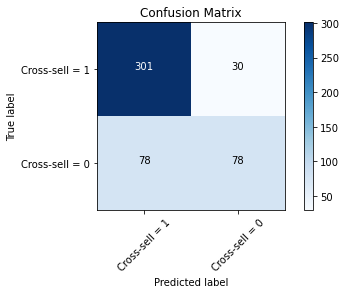

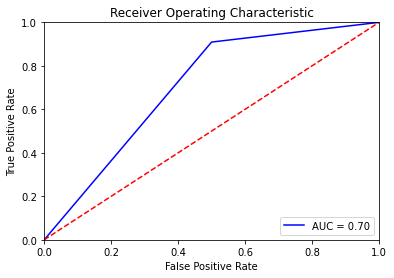

In [20]:
# Base Logistic Model (Variables = LOGISTIC)

# Specify explanatory variables
X = chefs.loc[:, features_dict['logistic']]

# Specify response variable
y = chefs.loc[:, 'CROSS_SELL_SUCCESS']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            test_size    = 0.25,
            random_state = 219,
            stratify     = y)


# Instantiate a logistic regression model
LR = LogisticRegression(solver       = 'lbfgs',
                        C            = 1,
                        random_state = 219,
                        max_iter     = 10000)


# Fit the logistic model
LR = LR.fit(X_train, y_train)

# Predict on test set
LR_pred = LR.predict(X_test)


# Create a dataframe of variable coefficients
lr_coeff = pd.DataFrame(LR.coef_[0], X.columns, columns=['Coefficient'])

# Filter out coefficients that equal 0 and sort by descending
lr_coeff = lr_coeff[lr_coeff['Coefficient'] != 0]\
                    .sort_values('Coefficient', ascending = False)

# Instantiate scores
LR_train_score = LR.score(X_train, y_train).round(4)
LR_test_score  = LR.score(X_test, y_test).round(4)
LR_test_gap    = abs(LR_test_score - LR_train_score).round(4)
LR_auc_score   = roc_auc_score(y_true  = y_test, y_score = LR_pred).round(4)
LR_report      = classification_report(y_test, 
                                       LR_pred,
                                       target_names = ['Cross Sell Failed (0)',
                                                       'Cross Sell Successful (1)'])
# Score results
print(f"""
=================== MODEL SUMMARY ===================

Model Type: Logistic Regression

Model Size: {X.shape[1] + 1}

---------------------------------

LR Training Score : {LR_train_score}
LR Testing Score  : {LR_test_score}
LR Train-Test Gap : {LR_test_gap}

LR AUC Score      : {LR_auc_score}

---------------------------------

Coefficients:

{lr_coeff}
""")


##############################################################################
# Plot Confusion Matrix

# Unpack confusion matrix
LR_tn, \
LR_fp, \
LR_fn, \
LR_tp = confusion_matrix(y_true = y_test, y_pred = LR_pred).ravel()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, LR_pred, labels=[1,0])
np.set_printoptions(precision = 2)

# Assess performance by plotting non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes   = ['Cross-sell = 1','Cross-sell = 0'],
                      normalize = False,  
                      title     = 'Confusion Matrix')
plt.show()

##############################################################################
# Plot ROC & AUC

# Calculate the FPR and TPR for all thresholds of the classification
probs = LR.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, LR_pred)
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Source of code:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

<br><br>

## 2) Tuned Logistic Regression

In [21]:
# # LR Tuned (Variables = LOGISTIC)

# # Specify explanatory variables
# X = chefs.loc[:, features_dict['logistic']]

# # Instantiate scaler
# scaler = RobustScaler()

# # Fit scaler
# scaler.fit(X)

# # Transform explanatory variables
# X_scaled = scaler.transform(X)

# ########################################
# # RandomizedSearchCV
# ########################################

# # declaring a hyperparameter space
# C_space          = np.arange(0.1, 5.1, 0.1)
# warm_start_space = [True, False]
# solver_space     = ['newton-cg', 'sag', 'lbfgs', 'liblinear', 'saga']


# # creating a hyperparameter grid
# param_grid = {'C'          : C_space,
#               'warm_start' : warm_start_space,
#               'solver'     : solver_space}


# # INSTANTIATING the model object without hyperparameters
# LR_tuned = LogisticRegression(random_state = 219,
#                               max_iter     = 1000)


# # GridSearchCV object
# LR_tuned_cv = RandomizedSearchCV(estimator        = LR_tuned,   # the model object
#                               param_distributions = param_grid, # parameters to tune
#                               cv                  = 6,          # how many folds in cross-validation
#                               n_iter              = 500,        # number of combinations of hyperparameters to try
#                               random_state        = 219,        # starting point for random sequence
#                               scoring = make_scorer(
#                                         roc_auc_score,
#                                         needs_threshold = False))# scoring criteria (AUC) 


# # FITTING to the FULL DATASET (due to cross-validation)
# LR_tuned_cv.fit(X_scaled, y)


# # PREDICT step is not needed


# # printing the optimal parameters and best score
# #print("Tuned Parameters  :", LR_tuned.best_params_)
# #print("Tuned CV AUC      :", LR_tuned.best_score_.round(4))


# ##############################################################################
# # Create tuned model

# # Train-test split with stratification & scaled X
# X_train, X_test, y_train, y_test = train_test_split(
#             X,
#             y,
#             test_size    = 0.25,
#             random_state = 219,
#             stratify     = y)


# # Instantiate a logistic regression model
# LR_tuned = LR_tuned_cv.best_estimator_


# # Fit the logistic model
# LR_tuned = LR_tuned.fit(X_train, y_train)

# # Predict on test set
# LR_tuned_pred = LR_tuned.predict(X_test)

# # Create a dataframe of variable coefficients
# lr_tuned_coeff = pd.DataFrame(LR_tuned.coef_[0], X.columns, columns=['Coefficient'])

# # Filter out coefficients that equal 0 and sort by descending
# lr_tuned_coeff = lr_tuned_coeff[lr_tuned_coeff['Coefficient'] != 0]\
#                     .sort_values('Coefficient', ascending = False)

# # Instantiate scores
# LR_tuned_train_score = LR_tuned.score(X_train, y_train).round(4)
# LR_tuned_test_score  = LR_tuned.score(X_test, y_test).round(4)
# LR_tuned_test_gap    = abs(LR_tuned_test_score - LR_tuned_train_score).round(4)
# LR_tuned_auc_score   = roc_auc_score(y_true  = y_test, y_score = LR_tuned_pred).round(4)
# LR_tuned_report      = classification_report(y_test, 
#                                        LR_tuned_pred,
#                                        target_names = ['Cross Sell Failed (0)',
#                                                        'Cross Sell Successful (1)'])
# # Score results
# print(f"""
# =================== MODEL SUMMARY ===================

# Model Type: Logistic Regression Tuned

# Model Size: {X.shape[1] + 1}

# ---------------------------------

# LR Training Score : {LR_tuned_train_score}
# LR Testing Score  : {LR_tuned_test_score}
# LR Train-Test Gap : {LR_tuned_test_gap}

# LR AUC Score      : {LR_tuned_auc_score}

# ---------------------------------

# Coefficients:

# {lr_tuned_coeff}
# """)


# ##############################################################################
# # Plot Confusion Matrix

# # Unpack confusion matrix
# LR_tuned_tn, \
# LR_tuned_fp, \
# LR_tuned_fn, \
# LR_tuned_tp = confusion_matrix(y_true = y_test, y_pred = LR_tuned_pred).ravel()

# # Compute confusion matrix
# cnf_matrix = confusion_matrix(y_test, LR_tuned_pred, labels=[1,0])
# np.set_printoptions(precision = 2)

# # Assess performance by plotting non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, 
#                       classes   = ['Cross-sell = 1','Cross-sell = 0'],
#                       normalize = False,  
#                       title     = 'Confusion Matrix')
# plt.show()

# ##############################################################################
# # Plot ROC & AUC

# # Calculate the FPR and TPR for all thresholds of the classification
# probs = LR_tuned.predict_proba(X_test)
# preds = probs[:,1]
# fpr, tpr, threshold = metrics.roc_curve(y_test, LR_tuned_pred)
# roc_auc = metrics.auc(fpr, tpr)

# # Plot ROC
# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

# # Source of code:
# # https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

<br><br>

## 3) Decision Tree


=================== MODEL SUMMARY ===================

Model Type: Decision Tree

Model Size: 9

---------------------------------

Decision Tree Training Score : 0.7491
Decision Tree Testing Score  : 0.7659
Decision Tree Test-Gap       : 0.0168
Decision Tree AUC Score      : 0.7024

---------------------------------




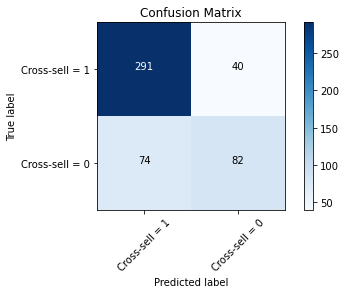

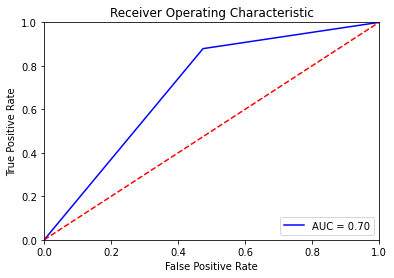

In [22]:
# Base Tree Model (Variables = TREE_SIG)

# Specify explanatory variables
X = chefs.loc[:, features_dict['tree_sig']]

# Save column names
column_names = X.columns

# Instantiate scaler
scaler = RobustScaler()

# Fit scaler
scaler.fit(X)

# Transform explanatory variables
X_scaled = scaler.transform(X)
    
    
# Specify response variable
y = chefs.loc[:, 'CROSS_SELL_SUCCESS']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
            X_scaled,
            y,
            test_size    = 0.25,
            random_state = 219,
            stratify     = y)              


# Instantiate a classification tree object
baseTree = DecisionTreeClassifier(criterion = 'gini',
                                  splitter  = 'best',
                                  max_depth = 4,
                                  min_samples_leaf = 25,
                                  random_state = 219)

# Fit the training data
baseTree = baseTree.fit(X_train, y_train)


# Predict cross-selling
baseTree_pred = baseTree.predict(X_test)


# Reassign column names
X_train = pd.DataFrame(X_train, columns = column_names)


#####################
# Save scores
baseTree_train_score = baseTree.score(X_train, y_train).round(4) # accuracy
baseTree_test_score  = baseTree.score(X_test, y_test).round(4)   # accuracy
baseTree_test_gap    = abs(baseTree_test_score - baseTree_train_score).round(4)
baseTree_auc_score   = roc_auc_score(y_true  = y_test,
                                      y_score = baseTree_pred).round(4) # auc
baseTree_report      = classification_report(y_test, 
                                             baseTree_pred,
                                             target_names = [
                                                 'Cross Sell Failed (0)',
                                                 'Cross Sell Successful (1)'])

#####################
# Score results
print(f"""
=================== MODEL SUMMARY ===================

Model Type: Decision Tree

Model Size: {X.shape[1] + 1}

---------------------------------

Decision Tree Training Score : {baseTree_train_score}
Decision Tree Testing Score  : {baseTree_test_score}
Decision Tree Test-Gap       : {baseTree_test_gap}
Decision Tree AUC Score      : {baseTree_auc_score}

---------------------------------

""")

##############################################################################
# Plot Confusion Matrix

# Unpack confusion matrix
baseTree_tn, \
baseTree_fp, \
baseTree_fn, \
baseTree_tp = confusion_matrix(y_true = y_test, y_pred = baseTree_pred).ravel()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, baseTree_pred, labels=[1,0])
np.set_printoptions(precision = 2)

# Assess performance by plotting non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes   = ['Cross-sell = 1','Cross-sell = 0'],
                      normalize = False,  
                      title     = 'Confusion Matrix')
plt.show()

##############################################################################
# Plot ROC & AUC

# Calculate the FPR and TPR for all thresholds of the classification
probs = baseTree.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, baseTree_pred)
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Source of code:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

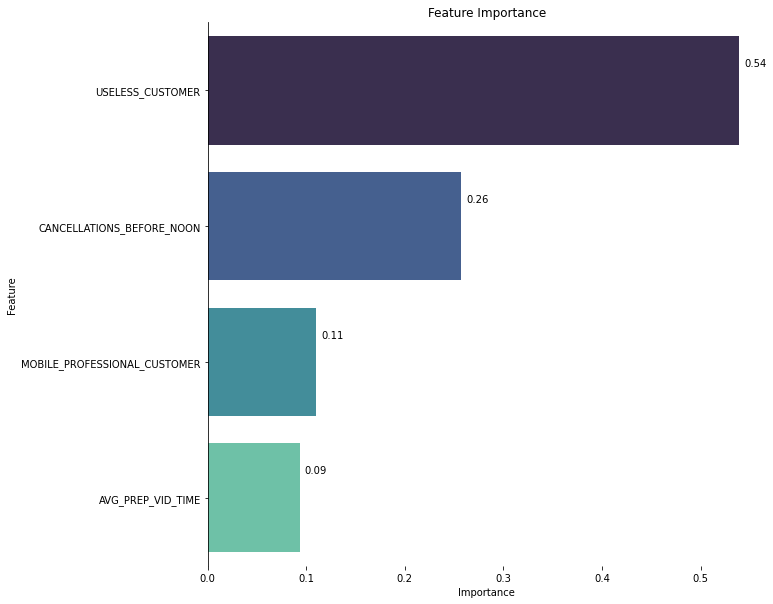

In [23]:
# Plot feature importance

# Create a dataframe of feature importance
feature_imp = pd.DataFrame(baseTree.feature_importances_, X.columns, columns=['Importance'])

# Filter out importance levels that equal 0 and sort by descending
feature_imp = feature_imp[feature_imp['Importance'] != 0]\
                            .sort_values('Importance', ascending = False)

# Plot

fig, ax = plt.subplots(figsize = (10, 10))

ax = sns.barplot(data    = feature_imp,
                 x       = 'Importance',
                 y       = feature_imp.index,
                 orient  = 'h',
                 palette = 'mako')

for p in ax.patches:    
    ax.annotate("%.2f" % p.get_width(), 
                   (p.get_x() + p.get_width(), 
                    p.get_y()), 
                    xytext=(5, -30), 
                    textcoords='offset points')


ax.set_yticks(np.arange(len(feature_imp)))
ax.set_yticklabels(feature_imp.index)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)


plt.show()

In [24]:
# Print significant features (1% and above)

#selector = SelectFromModel(baseTree, prefit = True, threshold = 0)
#X_train.columns[selector.get_support()].to_list()

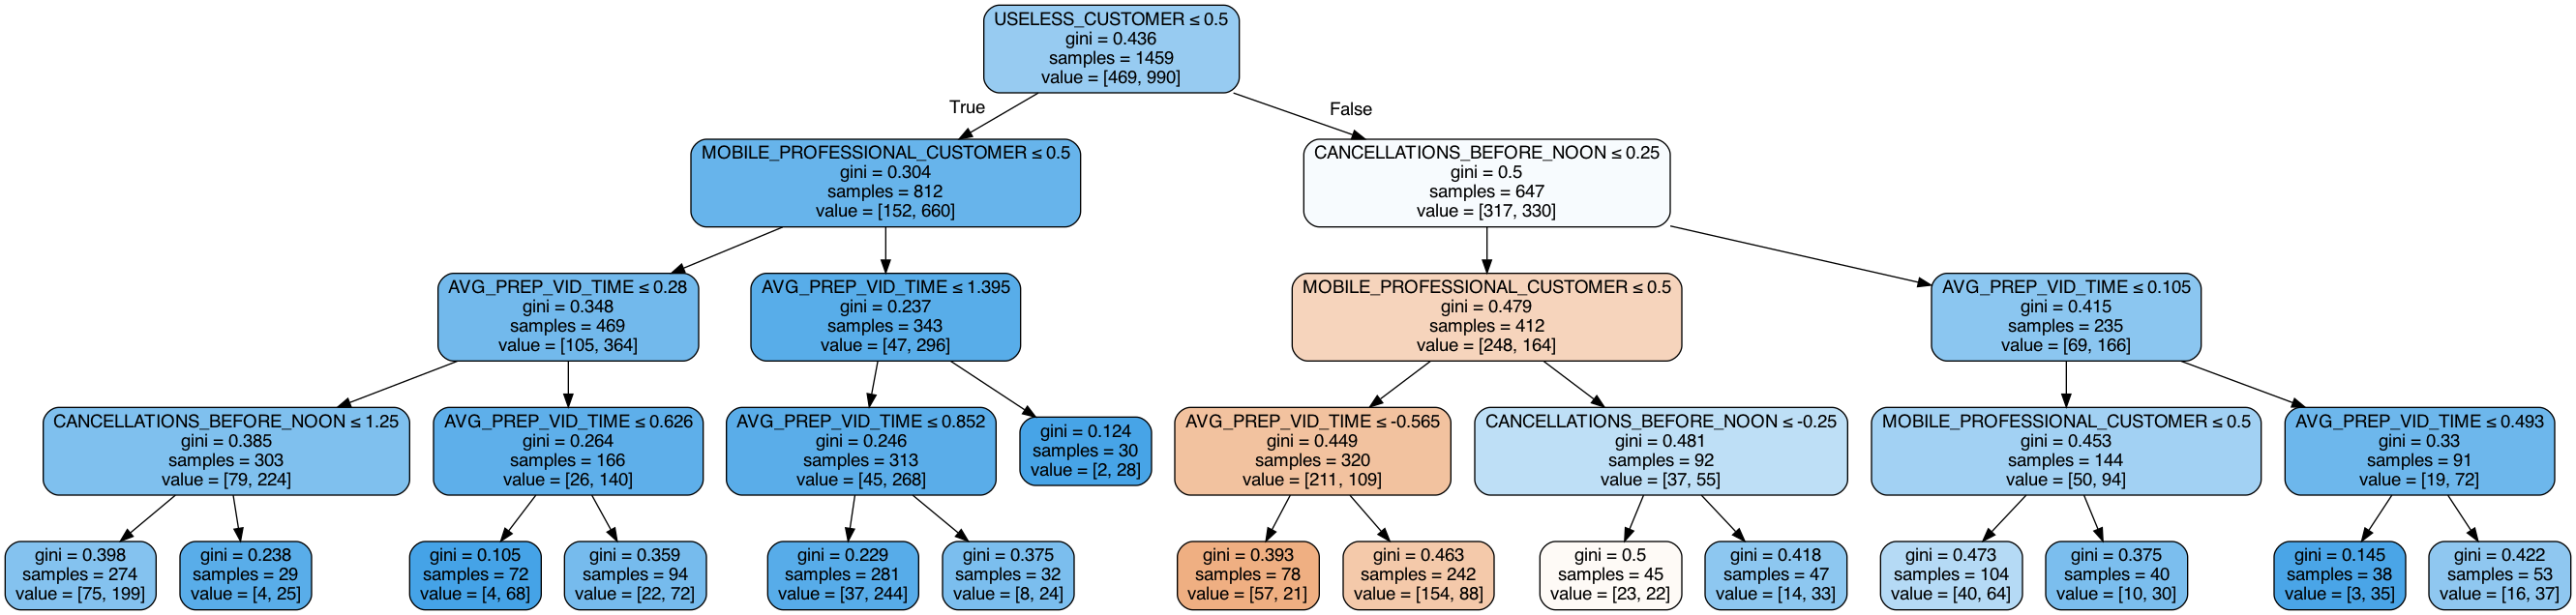

In [25]:
# Plot Decision Tree
display_tree(tree       = baseTree,
             feature_df = X_train)

<br><br>

## 4) Tuned Decision Tree

In [26]:
# # Tree Tuned (Variables = TREE_SIG)

# # Specify explanatory variables
# X = chefs.loc[:, features_dict['tree_sig']]

# # Save column names
# column_names = X.columns

# # Instantiate scaler
# scaler = RobustScaler()

# # Fit scaler
# scaler.fit(X)

# # Transform explanatory variables
# X_scaled = scaler.transform(X)


# # Train-test split with stratification
# X_train, X_test, y_train, y_test = train_test_split(
#             X_scaled,
#             y,
#             test_size    = 0.25,
#             random_state = 219,
#             stratify     = y)      

# # declaring a hyperparameter space
# criterion_space = ['gini', 'entropy']
# splitter_space  = ['best', 'random']
# depth_space     = np.arange(1, 9, 1)
# split_space     = np.arange(2, 700, 1)
# leaf_space      = np.arange(1, 500, 1)
# #features_space  = np.arange(1, 7, 1)



# # creating a hyperparameter grid
# param_grid = {'criterion'        : criterion_space,
#               'splitter'         : splitter_space,
#               'max_depth'        : depth_space,
#               'min_samples_leaf' : leaf_space,
# #              'max_features'     : features_space,
#               'min_samples_split': split_space}


# # INSTANTIATING the model object without hyperparameters
# tuned_tree = DecisionTreeClassifier(random_state = 219)


# # RandomizedSearchCV object
# tuned_tree = RandomizedSearchCV(estimator             = tuned_tree,
#                                 param_distributions   = param_grid,
#                                 cv                    = 5,
#                                 n_iter                = 500,
#                                 random_state          = 219,
#                                 scoring = make_scorer(roc_auc_score,
#                                          needs_threshold = False))


# # FITTING to the FULL DATASET (due to cross-validation)
# tuned_tree.fit(X_scaled, y)


# # printing the optimal parameters and best score
# print(f"""
# Best Parameters  :

# {tuned_tree.best_params_}


# """)

# ##############################################################################
# # Create tuned model

# # Instantiate a logistic regression model
# tree_tuned = tuned_tree.best_estimator_


# # Fit the logistic model
# tree_tuned = tree_tuned.fit(X_train, y_train)


# # Predict on test set
# tree_tuned_pred = tree_tuned.predict(X_test)


# # Reassign column names
# X_train = pd.DataFrame(X_train, columns = column_names)


# # Instantiate scores
# tree_tuned_train_score = tree_tuned.score(X_train, y_train).round(4)
# tree_tuned_test_score  = tree_tuned.score(X_test, y_test).round(4)
# tree_tuned_test_gap    = abs(tree_tuned_test_score - tree_tuned_train_score).round(4)
# tree_tuned_auc_score   = roc_auc_score(y_true  = y_test, y_score = tree_tuned_pred).round(4)
# tree_tuned_report      = classification_report(y_test, 
#                                        tree_tuned_pred,
#                                                target_names = ['Cross Sell Failed (0)',
#                                                                'Cross Sell Successful (1)'])
# # Score results
# print(f"""
# =================== MODEL SUMMARY ===================

# Model Type: Decision Tree Tuned

# Model Size: {X.shape[1] + 1}

# ---------------------------------

# Tuned Tree Training Score : {tree_tuned_train_score}
# Tuned Tree Testing Score  : {tree_tuned_test_score}
# Tuned Tree Train-Test Gap : {tree_tuned_test_gap}

# Tuned Tree AUC Score      : {tree_tuned_auc_score}

# ---------------------------------

# """)


# ##############################################################################
# # Plot Confusion Matrix

# # Unpack confusion matrix
# tree_tuned_tn, \
# tree_tuned_fp, \
# tree_tuned_fn, \
# tree_tuned_tp = confusion_matrix(y_true = y_test, y_pred = tree_tuned_pred).ravel()

# # Compute confusion matrix
# cnf_matrix = confusion_matrix(y_test, tree_tuned_pred, labels=[1,0])
# np.set_printoptions(precision = 2)

# # Assess performance by plotting non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, 
#                       classes   = ['Cross-sell = 1','Cross-sell = 0'],
#                       normalize = False,  
#                       title     = 'Confusion Matrix')
# plt.show()

# ##############################################################################
# # Plot ROC & AUC

# # Calculate the FPR and TPR for all thresholds of the classification
# probs = tree_tuned.predict_proba(X_test)
# preds = probs[:,1]
# fpr, tpr, threshold = metrics.roc_curve(y_test, tree_tuned_pred)
# roc_auc = metrics.auc(fpr, tpr)

# # Plot ROC
# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

# # Source of code:
# # https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

In [27]:
# # Plot feature importance

# # Create a dataframe of feature importance
# feature_imp = pd.DataFrame(tree_tuned.feature_importances_, 
#                            X.columns, columns=['Importance'])

# # Filter out importance levels that equal 0 and sort by descending
# feature_imp = feature_imp[feature_imp['Importance'] != 0]\
#                             .sort_values('Importance', ascending = False)

# # Plot

# fig, ax = plt.subplots(figsize = (10, 10))

# ax = sns.barplot(data    = feature_imp,
#                  x       = 'Importance',
#                  y       = feature_imp.index,
#                  orient  = 'h',
#                  palette = 'mako')

# for p in ax.patches:    
#     ax.annotate("%.2f" % p.get_width(), 
#                    (p.get_x() + p.get_width(), 
#                     p.get_y()), 
#                     xytext=(5, -30), 
#                     textcoords='offset points')


# ax.set_yticks(np.arange(len(feature_imp)))
# ax.set_yticklabels(feature_imp.index)
# ax.set_xlabel('Importance')
# ax.set_ylabel('Feature')
# ax.set_title('Feature Importance')
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)


# plt.show()

<br><br>

---

## 5) Random Forest


=================== MODEL SUMMARY ===================

Model Type: Random Forest

Model Size: 18

---------------------------------

RF Training Score : 0.8218
RF Testing Score  : 0.7782
RF Train-Test Gap : 0.0436

RF AUC Score      : 0.7081

---------------------------------




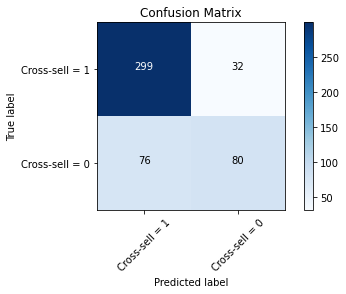

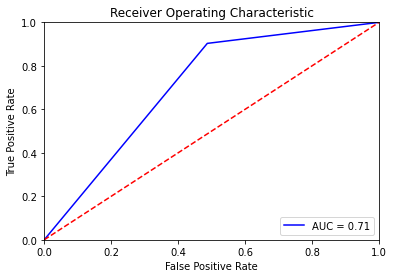

In [28]:
# Base Random Forest (Variables = FOREST)


##############################################################################
# Prepare data

# Specify explanatory variables
X = chefs.loc[:, features_dict['forest']]

# Save column names
column_names = X.columns

# Instantiate scaler
scaler = RobustScaler()

# Fit scaler
scaler.fit(X)

# Transform explanatory variables
X_scaled = scaler.transform(X)


# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
            X_scaled,
            y,
            test_size    = 0.25,
            random_state = 219,
            stratify     = y)      

# Reassign column names
X_train = pd.DataFrame(X_train, columns = column_names)

##############################################################################
# Create Model

# INSTANTIATING a random forest model with default values
rf_default = RandomForestClassifier(n_estimators     = 1000,
                                    criterion        = 'gini',
                                    max_depth        = 8,
                                    min_samples_leaf = 1,
                                    bootstrap        = True,
                                    warm_start       = False,
                                    random_state     = 219)

# FITTING the training data
rf_default = rf_default.fit(X_train, y_train)


# PREDICTING based on the testing set
rf_default_pred = rf_default.predict(X_test)


# Instantiate scores
rf_train_score = rf_default.score(X_train, y_train).round(4)
rf_test_score  = rf_default.score(X_test, y_test).round(4)
rf_test_gap    = abs(rf_test_score - rf_train_score).round(4)
rf_auc_score   = roc_auc_score(y_true  = y_test, y_score = rf_default_pred).round(4)
rf_report      = classification_report(y_test, 
                                       rf_default_pred,
                                       target_names = ['Cross Sell Failed (0)',
                                                       'Cross Sell Successful (1)'])
# Print results
print(f"""
=================== MODEL SUMMARY ===================

Model Type: Random Forest

Model Size: {X.shape[1] + 1}

---------------------------------

RF Training Score : {rf_train_score}
RF Testing Score  : {rf_test_score}
RF Train-Test Gap : {rf_test_gap}

RF AUC Score      : {rf_auc_score}

---------------------------------

""")


##############################################################################
# Plot Confusion Matrix

# Unpack confusion matrix
rf_tn, \
rf_fp, \
rf_fn, \
rf_tp = confusion_matrix(y_true = y_test, y_pred = rf_default_pred).ravel()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, rf_default_pred, labels=[1,0])
np.set_printoptions(precision = 2)

# Assess performance by plotting non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes   = ['Cross-sell = 1','Cross-sell = 0'],
                      normalize = False,  
                      title     = 'Confusion Matrix')
plt.show()

##############################################################################
# Plot ROC & AUC

# Calculate the FPR and TPR for all thresholds of the classification
probs = rf_default.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, rf_default_pred)
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Source of code:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

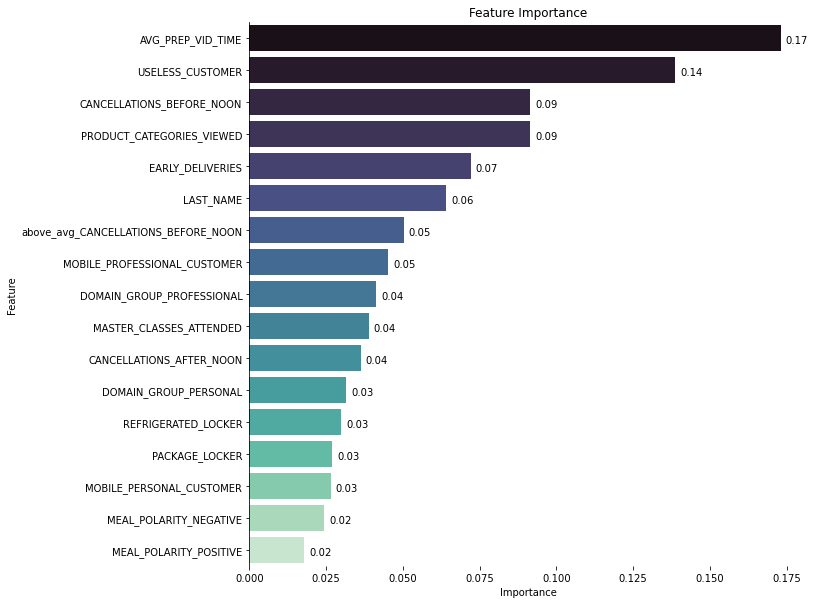

In [29]:
# Plot feature importance

# Create a dataframe of feature importance
feature_imp = pd.DataFrame(rf_default.feature_importances_, X.columns, columns=['Importance'])

# Filter out importance levels that equal 0 and sort by descending
feature_imp = feature_imp[feature_imp['Importance'] != 0]\
                            .sort_values('Importance', ascending = False)

# Plot

fig, ax = plt.subplots(figsize = (10, 10))

ax = sns.barplot(data    = feature_imp,
                 x       = 'Importance',
                 y       = feature_imp.index,
                 orient  = 'h',
                 palette = 'mako')

for p in ax.patches:    
    ax.annotate("%.2f" % p.get_width(), 
                   (p.get_x() + p.get_width(), 
                    p.get_y()), 
                    xytext=(5, -18), 
                    textcoords='offset points')


ax.set_yticks(np.arange(len(feature_imp)))
ax.set_yticklabels(feature_imp.index)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)


plt.show()

<br><br>

## 6) Tuned Random Forest

In [30]:
# Check best parameters
#forest_cv.best_params_


=================== MODEL SUMMARY ===================

Model Type: Random Forest Tuned

Model Size: 19

---------------------------------

Tuned Forest Training Score : 0.8307
Tuned Forest Testing Score  : 0.8563
Tuned Forest Train-Test Gap : 0.0256

Tuned Forest AUC Score      : 0.8095

---------------------------------




/Users/jackdaoud/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:369: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


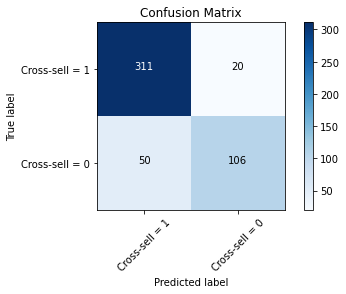

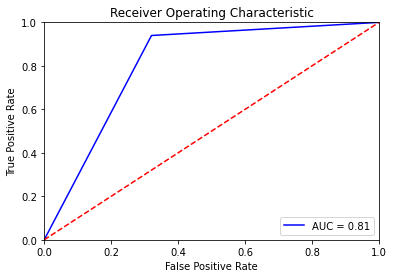

In [31]:
# Tuned Random Forest (Variables = GBM_SIG2)

##############################################################################
# Prepare data

# Specify explanatory variables
X = chefs.loc[:, features_dict['gbm_sig2']]

# Save column names
column_names = X.columns

# Instantiate scaler
scaler = RobustScaler()

# Fit scaler
scaler.fit(X)

# Transform explanatory variables
X_scaled = scaler.transform(X)


# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            test_size    = 0.25,
            random_state = 219,
            stratify     = y)      

##############################################################################
# Tune Hyperparameters

# declaring a hyperparameter space
estimator_space  = np.arange(140, 180, 10)
criterion_space  = ['gini', 'entropy']
depth_space      = np.arange(5, 9, 1)
#leaf_space       = np.arange(1, 10, 1)
bootstrap_space  = [True, False]
warm_start_space = [True, False]
#split_space      = np.arange(1, 525, 25)
#features_space   = np.arange(1, 14, 1)


# creating a hyperparameter grid
param_grid = {'n_estimators'     : estimator_space,
              'criterion'        : criterion_space,
              'max_depth'        : depth_space,
#              'min_samples_leaf' : leaf_space,
              'bootstrap'        : bootstrap_space,
              'warm_start'       : warm_start_space}


# INSTANTIATING the model object without hyperparameters
forest_grid = RandomForestClassifier(random_state = 219)


# GridSearchCV object
forest_cv = RandomizedSearchCV(estimator           = forest_grid,
                               param_distributions = param_grid,
                               cv           = 3,
                               n_iter       = 10,
                               random_state = 219,
                               scoring      = make_scorer(roc_auc_score,
                                              needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
forest_cv.fit(X, y)


# PREDICT step is not needed


##############################################################################
# Create tuned model

# Instantiate a logistic regression model
rf_tuned = forest_cv.best_estimator_


# Fit the logistic model
rf_tuned = rf_tuned.fit(X_train, y_train)


# Predict on test set
rf_tuned_pred = rf_tuned.predict(X_test)


# Reassign column names
X_train = pd.DataFrame(X_train, columns = column_names)


# Instantiate scores
rf_tuned_train_score = rf_tuned.score(X_train, y_train).round(4)
rf_tuned_test_score  = rf_tuned.score(X_test, y_test).round(4)
rf_tuned_test_gap    = abs(rf_tuned_test_score - rf_tuned_train_score).round(4)
rf_tuned_auc_score   = roc_auc_score(y_true  = y_test, y_score = rf_tuned_pred).round(4)
rf_tuned_report      = classification_report(y_test, 
                                       rf_tuned_pred,
                                       target_names = ['Cross Sell Failed (0)',
                                                       'Cross Sell Successful (1)'])
# Score results
print(f"""
=================== MODEL SUMMARY ===================

Model Type: Random Forest Tuned

Model Size: {X.shape[1] + 1}

---------------------------------

Tuned Forest Training Score : {rf_tuned_train_score}
Tuned Forest Testing Score  : {rf_tuned_test_score}
Tuned Forest Train-Test Gap : {rf_tuned_test_gap}

Tuned Forest AUC Score      : {rf_tuned_auc_score}

---------------------------------

""")


##############################################################################
# Plot Confusion Matrix

# Unpack confusion matrix
rf_tuned_tn, \
rf_tuned_fp, \
rf_tuned_fn, \
rf_tuned_tp = confusion_matrix(y_true = y_test, y_pred = rf_tuned_pred).ravel()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, rf_tuned_pred, labels=[1,0])
np.set_printoptions(precision = 2)

# Assess performance by plotting non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes   = ['Cross-sell = 1','Cross-sell = 0'],
                      normalize = False,  
                      title     = 'Confusion Matrix')
plt.show()

##############################################################################
# Plot ROC & AUC

# Calculate the FPR and TPR for all thresholds of the classification
probs = rf_tuned.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, rf_tuned_pred)
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Source of code:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

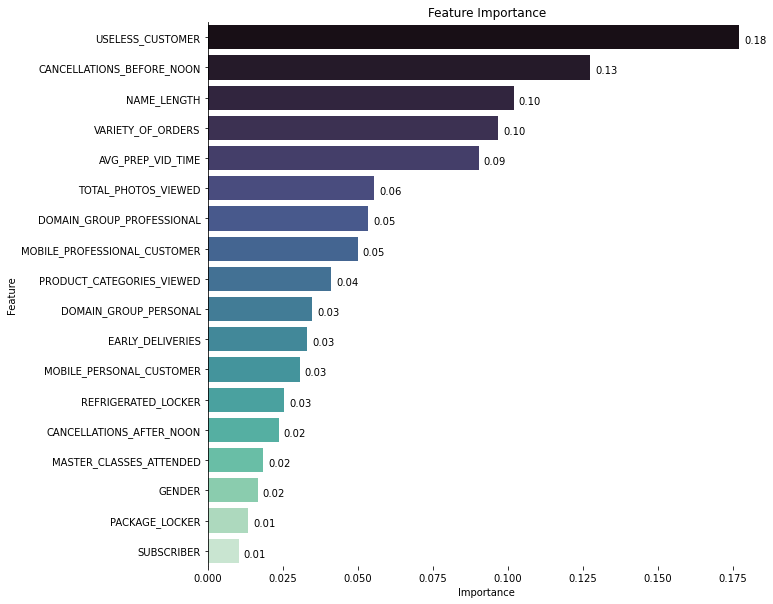

In [32]:
# Plot feature importance

# Create a dataframe of feature importance
feature_imp = pd.DataFrame(rf_tuned.feature_importances_, X.columns, columns=['Importance'])

# Filter out importance levels that equal 0 and sort by descending
feature_imp = feature_imp[feature_imp['Importance'] != 0]\
                            .sort_values('Importance', ascending = False)

# Plot

fig, ax = plt.subplots(figsize = (10, 10))

ax = sns.barplot(data    = feature_imp,
                 x       = 'Importance',
                 y       = feature_imp.index,
                 orient  = 'h',
                 palette = 'mako')

for p in ax.patches:    
    ax.annotate("%.2f" % p.get_width(), 
                   (p.get_x() + p.get_width(), 
                    p.get_y()), 
                    xytext=(5, -18), 
                    textcoords='offset points')


ax.set_yticks(np.arange(len(feature_imp)))
ax.set_yticklabels(feature_imp.index)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)


plt.show()

<br><br>

## 7) Gradient Boosted Machines


=================== MODEL SUMMARY ===================

Model Type: GBM

Model Size: 19

---------------------------------

GBM Training Score : 0.8088
GBM Testing Score  : 0.768
GBM Train-Test Gap : 0.0408

GBM AUC Score      : 0.6971

---------------------------------




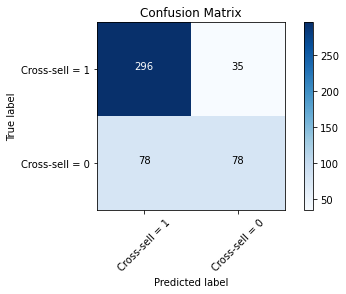

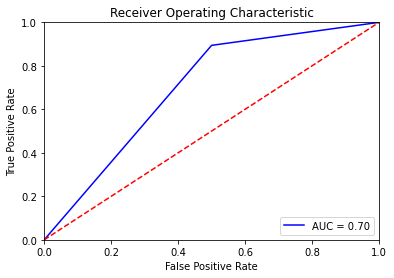

In [33]:
# GBM Model


##############################################################################
# Prepare data

# Specify explanatory variables
X = chefs.loc[:, features_dict['gbm_sig2']]

# Specify response variable
y = chefs.loc[:, 'CROSS_SELL_SUCCESS']


# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            test_size    = 0.25,
            random_state = 219,
            stratify     = y)      


##############################################################################
# Create model

# INSTANTIATING the model object without hyperparameters
gbm_default = GradientBoostingClassifier(loss          = 'deviance',
                                         learning_rate = 0.1,
                                         n_estimators  = 100,
                                         criterion     = 'friedman_mse',
                                         max_depth     = 3,
                                         warm_start    = False,
                                         random_state  = 219)

# FIT step is needed as we are not using .best_estimator
gbm_default = gbm_default.fit(X_train, y_train)


# PREDICTING based on the testing set
gbm_default_pred = gbm_default.predict(X_test)


# Instantiate scores
gbm_default_train_score = gbm_default.score(X_train, y_train).round(4)
gbm_default_test_score  = gbm_default.score(X_test, y_test).round(4)
gbm_default_test_gap    = abs(gbm_default_test_score - gbm_default_train_score).round(4)
gbm_default_auc_score   = roc_auc_score(y_true  = y_test, y_score = gbm_default_pred).round(4)
gbm_default_report      = classification_report(y_test, 
                                       gbm_default_pred,
                                       target_names = ['Cross Sell Failed (0)',
                                                       'Cross Sell Successful (1)'])
# Score results
print(f"""
=================== MODEL SUMMARY ===================

Model Type: GBM

Model Size: {X.shape[1] + 1}

---------------------------------

GBM Training Score : {gbm_default_train_score}
GBM Testing Score  : {gbm_default_test_score}
GBM Train-Test Gap : {gbm_default_test_gap}

GBM AUC Score      : {gbm_default_auc_score}

---------------------------------

""")


##############################################################################
# Plot Confusion Matrix

# Unpack confusion matrix
gbm_default_tn, \
gbm_default_fp, \
gbm_default_fn, \
gbm_default_tp = confusion_matrix(y_true = y_test, y_pred = gbm_default_pred).ravel()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, gbm_default_pred, labels=[1,0])
np.set_printoptions(precision = 2)

# Assess performance by plotting non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes   = ['Cross-sell = 1','Cross-sell = 0'],
                      normalize = False,  
                      title     = 'Confusion Matrix')
plt.show()

##############################################################################
# Plot ROC & AUC

# Calculate the FPR and TPR for all thresholds of the classification
probs = gbm_default.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, gbm_default_pred)
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Source of code:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python


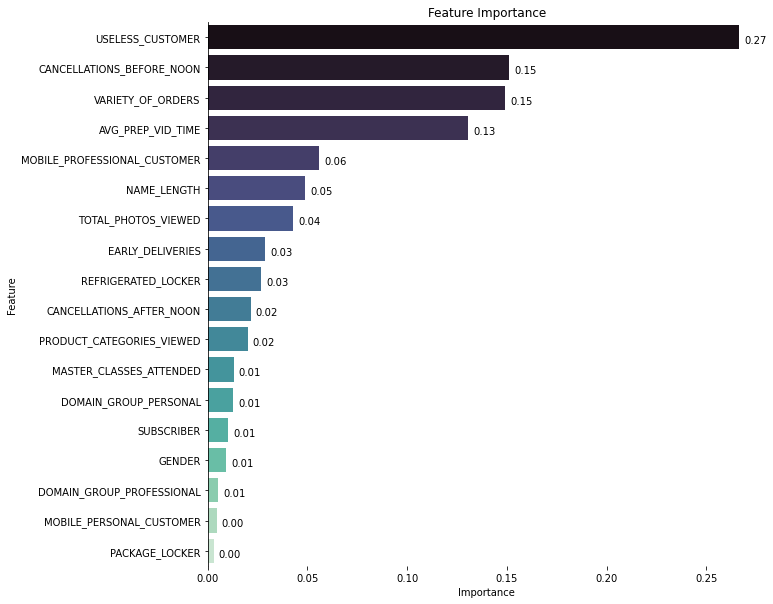

In [34]:
# Plot feature importance

# Create a dataframe of feature importance
feature_imp = pd.DataFrame(gbm_default.feature_importances_, X.columns, columns=['Importance'])

# Filter out importance levels that equal 0 and sort by descending
feature_imp = feature_imp[feature_imp['Importance'] != 0]\
                            .sort_values('Importance', ascending = False)

# Plot

fig, ax = plt.subplots(figsize = (10, 10))

ax = sns.barplot(data    = feature_imp,
                 x       = 'Importance',
                 y       = feature_imp.index,
                 orient  = 'h',
                 palette = 'mako')

for p in ax.patches:    
    ax.annotate("%.2f" % p.get_width(), 
                   (p.get_x() + p.get_width(), 
                    p.get_y()), 
                    xytext=(5, -18), 
                    textcoords='offset points')


ax.set_yticks(np.arange(len(feature_imp)))
ax.set_yticklabels(feature_imp.index)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)


plt.show()

In [35]:
# # Print significant features (1% and above)

# selector = SelectFromModel(gbm_default, prefit = True, threshold = 0.01)
# X_train.columns[selector.get_support()].to_list()

<br><br>

## 8) Tuned Gradient Boosted Machines

In [36]:
# Check best parameters
#gbm_cv.best_params_


=================== MODEL SUMMARY ===================

Model Type: GBM Tuned

Model Size: 19

---------------------------------

Tuned GBM Training Score : 0.9102
Tuned GBM Testing Score  : 0.9138
Tuned GBM Train-Test Gap : 0.0036

Tuned GBM AUC Score      : 0.8857

---------------------------------




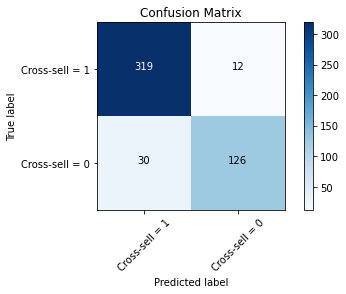

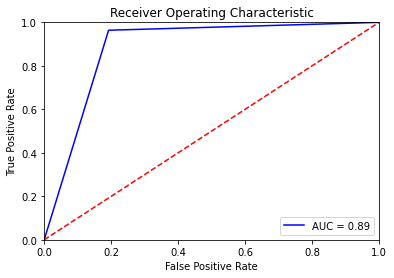

In [37]:
# GBM Tuned

# declaring a hyperparameter space
learn_space        = np.arange(0.1, 3.0, 0.1)
estimator_space    = np.arange(120, 150, 10)
depth_space        = np.arange(3, 5, 1)
warm_start_space   = [True, False]

#min_split_space    = np.arange(2, 400, 100)
#max_features_space = ['auto', 'sqrt', 'log2']
#loss_space         = ['deviance', 'exponential']
#criterion_space    = ['friedman_mse', 'mse', 'mae']

# creating a hyperparameter grid
param_grid = {'learning_rate'     : learn_space,
              'n_estimators'      : estimator_space,
              'max_depth'         : depth_space,
#              'min_samples_split' : min_split_space,
#              'max_features'      : max_features_space,
#              'loss'              : loss_space,
#              'criterion'         : criterion_space,
              'warm_start'        : warm_start_space}

# INSTANTIATING the model object without hyperparameters
gbm_grid = GradientBoostingClassifier(random_state = 219)


# GridSearchCV object
gbm_cv = RandomizedSearchCV(estimator          = gbm_grid,
                           param_distributions = param_grid,
                           cv                  = 3,
                           n_iter              = 10,
                           random_state        = 219,
                           scoring             = make_scorer(roc_auc_score,
                                                 needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
gbm_cv.fit(X, y)


##############################################################################
# Create tuned model

# Instantiate a logistic regression model
gbm_tuned = gbm_cv.best_estimator_

# FIT step is needed as we are not using .best_estimator
gbm_tuned = gbm_tuned.fit(X_train, y_train)


# PREDICTING based on the testing set
gbm_tuned_pred = gbm_tuned.predict(X_test)


# Instantiate scores
gbm_tuned_train_score = gbm_tuned.score(X_train, y_train).round(4)
gbm_tuned_test_score  = gbm_tuned.score(X_test, y_test).round(4)
gbm_tuned_test_gap    = abs(gbm_tuned_test_score - gbm_tuned_train_score).round(4)
gbm_tuned_auc_score   = roc_auc_score(y_true  = y_test, y_score = gbm_tuned_pred).round(4)
gbm_tuned_report      = classification_report(y_test, 
                                       gbm_tuned_pred,
                                       target_names = ['Cross Sell Failed (0)',
                                                       'Cross Sell Successful (1)'])
# Score results
print(f"""
=================== MODEL SUMMARY ===================

Model Type: GBM Tuned

Model Size: {X.shape[1] + 1}

---------------------------------

Tuned GBM Training Score : {gbm_tuned_train_score}
Tuned GBM Testing Score  : {gbm_tuned_test_score}
Tuned GBM Train-Test Gap : {gbm_tuned_test_gap}

Tuned GBM AUC Score      : {gbm_tuned_auc_score}

---------------------------------

""")


##############################################################################
# Plot Confusion Matrix

# Unpack confusion matrix
gbm_tuned_tn, \
gbm_tuned_fp, \
gbm_tuned_fn, \
gbm_tuned_tp = confusion_matrix(y_true = y_test, y_pred = gbm_tuned_pred).ravel()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, gbm_tuned_pred, labels=[1,0])
np.set_printoptions(precision = 2)

# Assess performance by plotting non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes   = ['Cross-sell = 1','Cross-sell = 0'],
                      normalize = False,  
                      title     = 'Confusion Matrix')
plt.show()

##############################################################################
# Plot ROC & AUC

# Calculate the FPR and TPR for all thresholds of the classification
probs = gbm_tuned.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, gbm_tuned_pred)
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Source of code:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

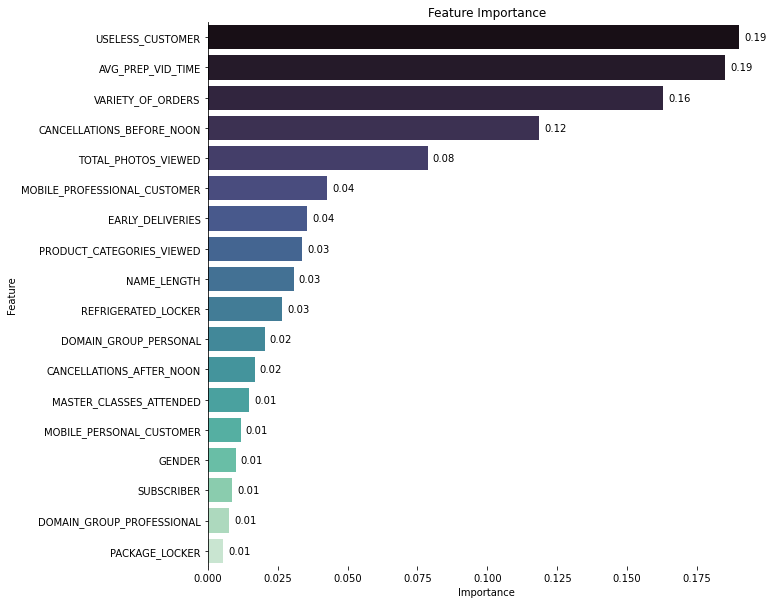

In [38]:
# Plot feature importance

# Create a dataframe of feature importance
feature_imp = pd.DataFrame(gbm_tuned.feature_importances_, X.columns, columns=['Importance'])

# Filter out importance levels that equal 0 and sort by descending
feature_imp = feature_imp[feature_imp['Importance'] != 0]\
                            .sort_values('Importance', ascending = False)

# Plot

fig, ax = plt.subplots(figsize = (10, 10))

ax = sns.barplot(data    = feature_imp,
                 x       = 'Importance',
                 y       = feature_imp.index,
                 orient  = 'h',
                 palette = 'mako')

for p in ax.patches:    
    ax.annotate("%.2f" % p.get_width(), 
                   (p.get_x() + p.get_width(), 
                    p.get_y()), 
                    xytext=(5, -15), 
                    textcoords='offset points')


ax.set_yticks(np.arange(len(feature_imp)))
ax.set_yticklabels(feature_imp.index)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)


plt.show()

In [39]:
# # Print significant features (1% and above)

# selector = SelectFromModel(gbm_tuned, prefit = True, threshold = 0.01)
# X_train.columns[selector.get_support()].to_list()

<br><br>

## Comparison

In [40]:
# Print end result

# Time of script
t1 = time.time()

script_time = round((t1-t0)/60, 2)

# Compare results
print(f"""

======================================== Model Comparison ========================================



Model           Train Accuracy   Test Accuracy     Gap         AUC Score      TN,  FP, FN,  TP
-----           --------------   -------------     ------      ---------      ----------------
Logistic        {LR_train_score}           {LR_test_score}            {LR_test_gap}      {LR_auc_score}         {LR_tn, LR_fp, LR_fn, LR_tp}
Decision Tree   {baseTree_train_score}           {baseTree_test_score}            {baseTree_test_gap}      {baseTree_auc_score}         {baseTree_tn, baseTree_fp, baseTree_fn, baseTree_tp}
Random Forest   {rf_train_score}           {rf_test_score}            {rf_test_gap}      {rf_auc_score}         {rf_tn, rf_fp, rf_fn, rf_tp}
Tuned RF        {rf_tuned_train_score}           {rf_tuned_test_score}            {rf_tuned_test_gap}      {rf_tuned_auc_score}         {rf_tuned_tn, rf_tuned_fp, rf_tuned_fn, rf_tuned_tp}
GBM             {gbm_default_train_score}           {gbm_default_test_score}             {gbm_default_test_gap}      {gbm_default_auc_score}         {gbm_default_tn, gbm_default_fp, gbm_default_fn, gbm_default_tp}
Tuned GBM       {gbm_tuned_train_score}           {gbm_tuned_test_score}            {gbm_tuned_test_gap}      {gbm_tuned_auc_score}         {gbm_tuned_tn, gbm_tuned_fp, gbm_tuned_fn, gbm_tuned_tp}         



     /-----------------------------------------------------------------------------------\\
     | Tuned GBM is the best model with an AUC of {gbm_tuned_auc_score} and a train-test gap of {gbm_tuned_test_gap}  |
     \\-----------------------------------------------------------------------------------/


""")

# Tuned LR      {LR_tuned_test_gap}              {LR_tuned_auc_score}          {LR_tuned_tn, LR_tuned_fp, LR_tuned_fn, LR_tuned_tp}
# Tuned Tree    {tree_tuned_test_gap}              {tree_tuned_auc_score}         {tree_tuned_tn, tree_tuned_fp, tree_tuned_fn, tree_tuned_tp}




print(f"""

Total script run time: {script_time} minutes

""")



======================================== Model Comparison ========================================



Model           Train Accuracy   Test Accuracy     Gap         AUC Score      TN,  FP, FN,  TP
-----           --------------   -------------     ------      ---------      ----------------
Logistic        0.7581           0.7782            0.0201      0.7047         (78, 78, 30, 301)
Decision Tree   0.7491           0.7659            0.0168      0.7024         (82, 74, 40, 291)
Random Forest   0.8218           0.7782            0.0436      0.7081         (80, 76, 32, 299)
Tuned RF        0.8307           0.8563            0.0256      0.8095         (106, 50, 20, 311)
GBM             0.8088           0.768             0.0408      0.6971         (78, 78, 35, 296)
Tuned GBM       0.9102           0.9138            0.0036      0.8857         (126, 30, 12, 319)         



     /-----------------------------------------------------------------------------------\
     | Tuned GBM is the b